In [120]:
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import cmocean.cm as cmo

# Transports in pyfesom2
This is the example notebook for computing cross-section transports from FESOM2 data.
Transport across meridional and zonal sections can be computed with the cross_section_transport.py function. Sections that are neither zonal or meridional are supported, however the computation is experimental and no warranty is given for its correctness. The velocity data is needed on elements.

### Let's compute the transport across the Barents Sea Opening...

In [2]:
transport, section = pf.cross_section_transports('BSO',                                                  # select a section from the presets or [lon1, lon2, lat1, lat2]
                                                mesh_path='/Users/fheukamp/Desktop/fesom2_test_year/',   # directory of the mesh files
                                                data_path='/Users/fheukamp/Desktop/fesom2_test_year/',   # directory of the u, v, (T, S, uice, vice, m_ice, a_ice) files
                                                mesh_diag_path=None,                                     # absolute path to the mesh_diag_file or None if the same as mesh_path
                                                years=np.arange(2000,2001),                              # years to compute
                                                use_great_circle=True,                                   # compute the section as a great circle
                                                how='ori',                                               # 'ori' do not apply mean, 'mean' apply time mean
                                                add_IT=True,                                             # add the ice transport across the section
                                                add_TS=True,                                             # add temperature and salinity to the section
                                                add_extent=1                                             # the extent to look for gridcells nerby the section, choose large for low resolutions
                                               )

/Users/fheukamp/Desktop/fesom2_test_year/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/fheukamp/Desktop/fesom2_test_year/pickle_mesh_py3_fesom2
--> Loading the velocity data into memory, this may take some time...
[########################################] | 100% Completed |  0.7s
--> Loading the temperature and salinity data into memory, this may take some time...
[########################################] | 100% Completed |  0.3s
--> Loading the ice data into memory, this should be fast...
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
--> Done!


### Take a look at the output...
Two outputs are returned by the function: an xr.Dataset containing the transport data and a dictionary containing informations on the section

#### The section dictionary contains information about the section: 
- start and end coordinates
- name of the section in case a preset is used
- orientation of the section
- whether a great circle was used or not
- the years that were computed

#### The transport xr.Dataset containing the actual transport and additional data...

### First, define some plotting functions...

In [298]:
def PlotBackground(ax, section):
    
    ''''''
    gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="--",
    x_inline=True,
    y_inline=False,
    zorder=20,
    )
    
    if section['name'] == 'BSO':
        ax.set_extent([18, 21, 69, 75], crs=ccrs.PlateCarree())
    
        gl.xlocator = mticker.FixedLocator(
            [_ for _ in np.arange(15,26,1)],
        )
        gl.ylocator = mticker.FixedLocator(np.arange(70,76,1))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    
    elif section['name'] == 'BSX':
        ax.set_extent([62, 66, 74, 82], crs=ccrs.PlateCarree())
    
        gl.xlocator = mticker.FixedLocator(
            [_ for _ in np.arange(62,65,1)],
        )
        gl.ylocator = mticker.FixedLocator(np.arange(60,85,1))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, zorder=10, color='grey')

    gl.xlabel_style = {"size": 12, "rotation": 0}
    gl.ylabel_style = {"size": 12, "rotation": 0}

    return


def FindColorLevels(z, pcolor=True, div=True):
    '''
    '''
    min_lev = np.nanmin(z.flatten())
    max_lev = np.nanmax(z.flatten())
    
    if div:
        if np.abs(min_lev) > max_lev:
            if pcolor:
                levels=[-min_lev, min_lev]
            else:
                levels = np.arange(-min_lev, min_lev+min_lev/10, min_lev/10)

        elif np.abs(min_lev) < max_lev:
            if pcolor:
                levels=[-max_lev, max_lev]
            else:
                levels = np.arange(-max_lev, max_lev+max_lev/10, max_lev/10)
                
    else:
        levels = [min_lev, max_lev]
        
    return levels


def PlotSectionBirdview(transport, section, mesh):
    '''
    Plot the section from above
    '''
    
    # Set up figure 
    fig, ax = plt.subplots(1,1, figsize=(10,15), subplot_kw=dict(projection=ccrs.PlateCarree()))
    PlotBackground(ax, section)

    cb = ax.tripcolor(mesh.x2, mesh.y2, transport.elem_nods.values,transport.velocity_across.mean(dim=('time','nz1')), transform=ccrs.PlateCarree(), cmap='inferno', edgecolor='chartreuse')
    
    if section['orientation'] == 'meridional':
        ax.plot([section['lon_start'], section['lon_end']],[section['lat_start'], section['lat_end']], 'r-', transform=ccrs.PlateCarree())
    
    cbar = plt.colorbar(cb, ax=ax)
    cbar.set_label('depth averaged cross section velocity', fontsize=12)
    plt.show()
    return


def PlotDepthSection(transport, mesh_diag, param='velocity_across', cmap='RdBu_r', time='mean', unit='m/s', div=True, levels=None):
    '''
    Plot the depth section of the velocity on the original grid
    '''
    
    fig, axis = plt.subplots(1,1, figsize=(15,10))
    
    if time == 'mean':
        z = transport[param].mean(dim='time').transpose().values
    else:
        z = transport[param].sel(time=time, method='nearest').transpose().values

    # get rid of bathymetry values
    z = np.where(z==0, np.nan, z)

    # create the x grid by the cumulative sum of the horizontal extends of each cell and adding 0 at the first value
    x = np.insert(transport.horizontal_distance.cumsum().values,0,0) * 1e-3
    y = np.abs(mesh_diag.zbar.values)
    # find the color limits
    if levels==None:
        levels = FindColorLevels(z, pcolor=True, div=div)
    # Plot
    cb = axis.pcolormesh(x,y,z, cmap=cmap, vmin=levels[0], vmax=levels[-1], edgecolor='k')
    cbar = plt.colorbar(cb,ax=axis, orientation='horizontal', shrink=.7)
    cbar.set_label(param + ' in ' + unit, fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    axis.invert_yaxis()
    axis.set_ylim((500,0))
    axis.set_xlabel('distance from section start in km', fontsize=12)
    axis.set_ylabel('depth', fontsize=12)
    axis.tick_params(labelsize=12)

    return 

## Plot the results...
First, we need to load the mesh file and mesh_diag file

In [279]:
mesh = pf.load_mesh('/Users/fheukamp/Desktop/fesom2_test_year/')
mesh_diag = xr.open_dataset('/Users/fheukamp/Desktop/fesom2_test_year/fesom.mesh.diag.nc')

/Users/fheukamp/Desktop/fesom2_test_year/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/fheukamp/Desktop/fesom2_test_year/pickle_mesh_py3_fesom2


### Let's take a look at the section from a birds perspective...
The width of the single segments is defined by the two intersection coordinates of each element with the section

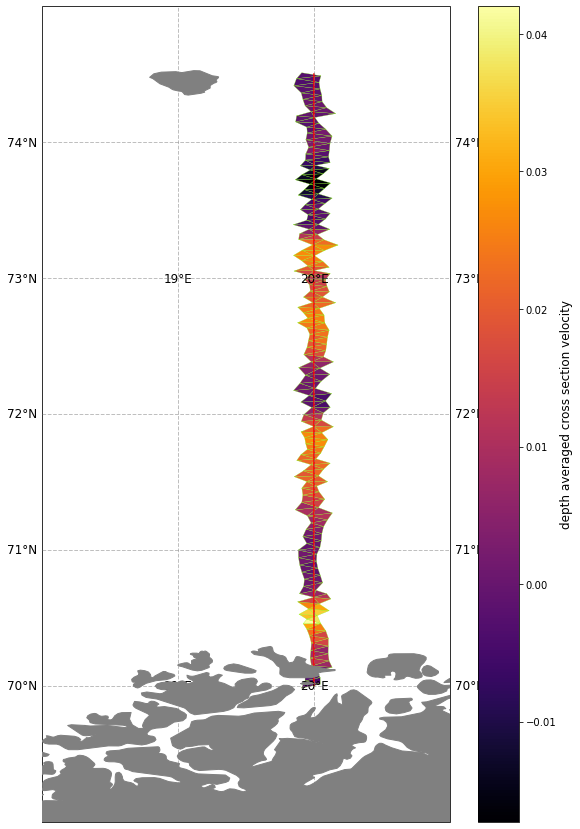

In [299]:
PlotSectionBirdview(transport, section, mesh)

### We can plot data of the depth-section on the original grid
This can be done for:
- velocity_across
- transport_across
- salt
- temp

The intersections of the single elements have a different length, hence the grid of the section is irregular in the horizontal dimension.  Since temperature and salinity are stored on nods by FESOM2, they are on a different mesh than the velocity data. To get temperature and salinity (as well as ice related variables) onto the velocity grid, the temperature/ salinity values of the three nods forming each single intersected element are averaged. 

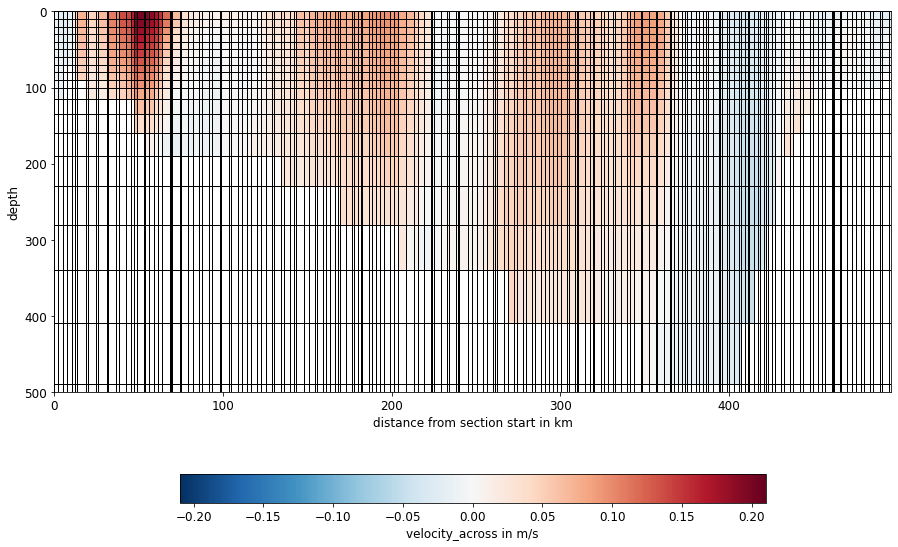

In [300]:
PlotDepthSection(transport, mesh_diag, param='velocity_across', unit='m/s', cmap='RdBu_r')

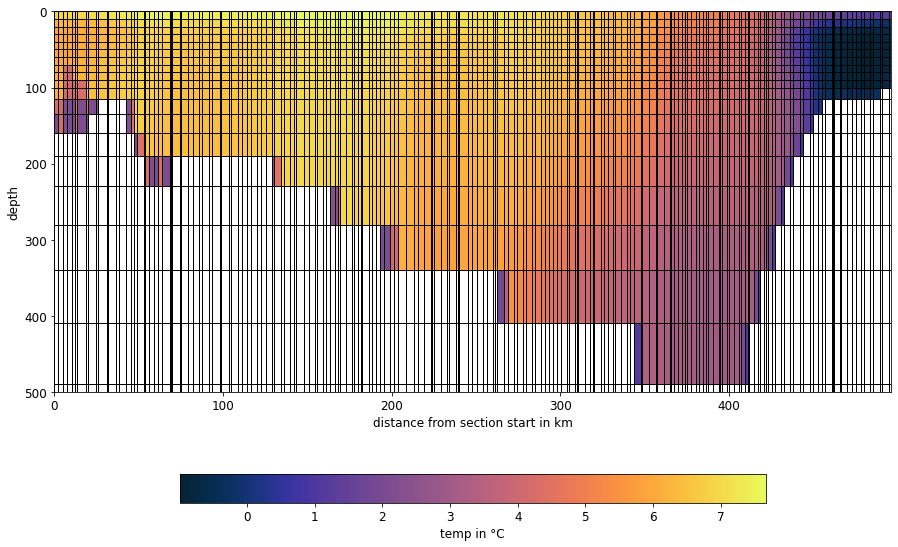

In [301]:
PlotDepthSection(transport, mesh_diag, param='temp', unit='°C', cmap=cmo.thermal, div=False)

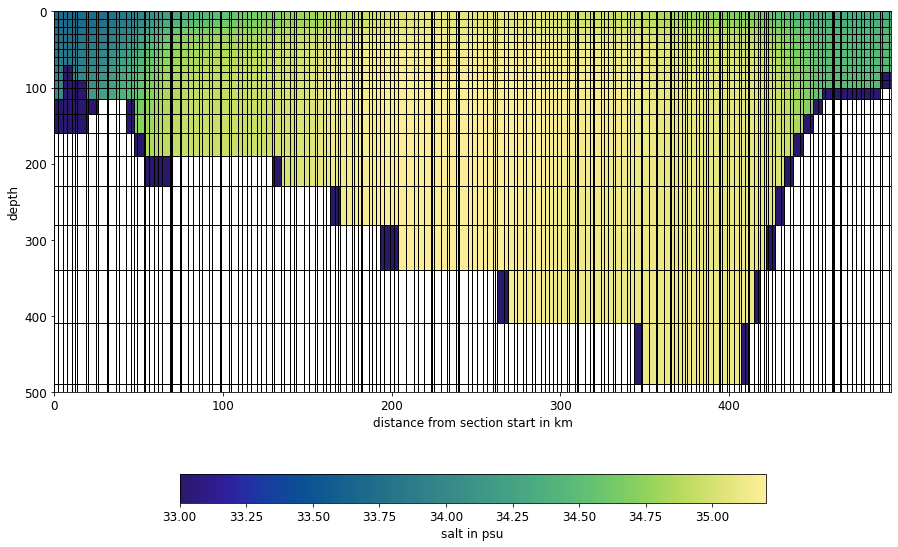

In [302]:
PlotDepthSection(transport, mesh_diag, param='salt', unit='psu', cmap=cmo.haline, div=False, levels=[33,35.2])

### Now we compute the net transport across the section as a timeseries...
We make use of xarrays build in sum() functions to compute the transport across the section. To get the transport we sum up the single cell transports stored in transport.transport_across over the horizontal and vertical dimensions ('elem','nz1') and converting m3/s to Sverdrups

In [303]:
net_transport = transport.transport_across.sum(dim=('elem','nz1')) * 1e-6

We recieve an xarray.DataArray containing the transport that we can easily plot with xarrays build in plotting routines:

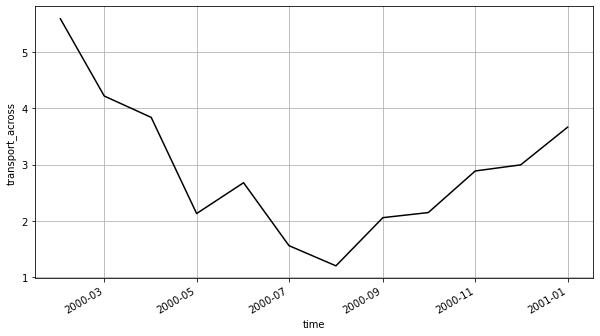

In [304]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.grid(':')

net_transport.plot(ax=ax, color='k')

### Add temperature/ salinity criteria to the transport...

Furthermore, it's easy to apply a temperature and/or salinity condition to compute only transports in specific TS ranges. For this we use the xarray.DataArray.where() function.   
Let's compute the warm/cold water transport, with water warmer/colder than 6°C. We set the transport in cells where the temperature is below/above 6°C to 0, so they do not contribute when we sum them up to recieve the total transport.

In [305]:
warm_water_transport = transport.transport_across.where(transport.temp > 6, 0).sum(dim=('elem','nz1')) * 1e-6
cold_water_transport = transport.transport_across.where(transport.temp <= 6, 0).sum(dim=('elem','nz1')) * 1e-6

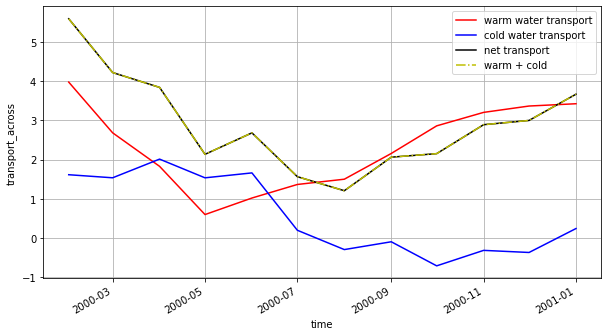

In [306]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.grid(':')

warm_water_transport.plot(ax=ax, color='r', label='warm water transport')
cold_water_transport.plot(ax=ax, color='b', label='cold water transport')
net_transport.plot(ax=ax, color='k', label='net transport')
(warm_water_transport + cold_water_transport).plot(ax=ax, color='y', linestyle='-.', label='warm + cold')

plt.legend()
plt.show()

## Ice transports
When the add_IT keyword is set to True, the sea-ice transport across the section is furthermore computed. As for temperature and salinity the sea-ice data is on nods and not elements. Thus, the three nods that form the intersected element are averaged to obtian one value for each intersected element. The transport is derived as:  a_ice * m_ice * cell_widths * ice_velocity  
Let's look at some other section bacause there is no ice transport through BSO...

In [307]:
transport_BSX, section_BSX = pf.cross_section_transports('BSX',                                                  # select a section from the presets or [lon1, lon2, lat1, lat2]
                                                        mesh_path='/Users/fheukamp/Desktop/fesom2_test_year/',   # directory of the mesh files
                                                        data_path='/Users/fheukamp/Desktop/fesom2_test_year/',   # directory of the u, v, (T, S, uice, vice, m_ice, a_ice) files
                                                        mesh_diag_path=None,                                     # absolute path to the mesh_diag_file or None if the same as mesh_path
                                                        years=np.arange(2000,2001),                              # years to compute
                                                        use_great_circle=True,                                   # compute the section as a great circle
                                                        how='ori',                                               # 'ori' do not apply mean, 'mean' apply time mean
                                                        add_IT=True,                                             # add the ice transport across the section
                                                        add_TS=True                                              # add temperature and salinity to the section
                                                       )

/Users/fheukamp/Desktop/fesom2_test_year/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/fheukamp/Desktop/fesom2_test_year/pickle_mesh_py3_fesom2
--> Loading the velocity data into memory, this may take some time...
[########################################] | 100% Completed |  0.6s
--> Loading the temperature and salinity data into memory, this may take some time...
[########################################] | 100% Completed |  0.3s
--> Loading the ice data into memory, this should be fast...
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
--> Done!


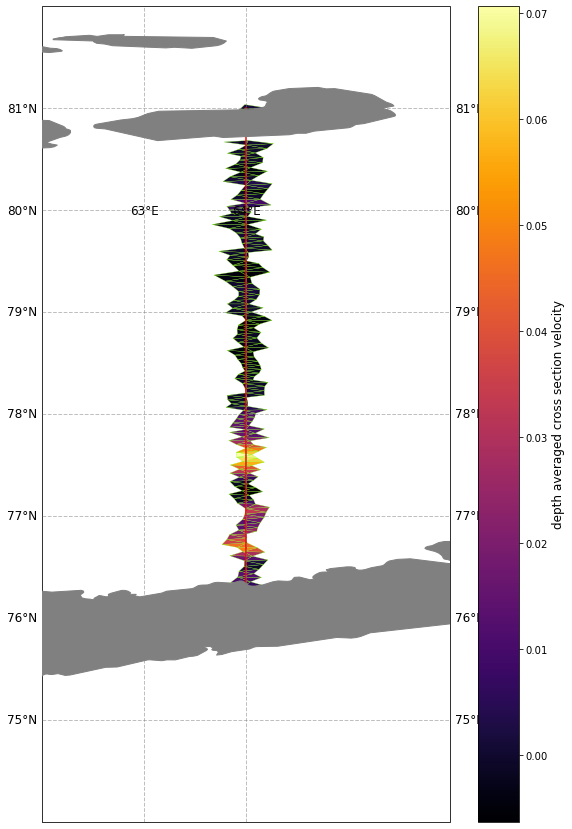

In [308]:
PlotSectionBirdview(transport_BSX, section_BSX, mesh)

To compute the net sea-ice transport across the section we simply sum up the ice transport of each cell

In [309]:
ice_transport = transport_BSX.ice_transport_across.sum(dim='elem')

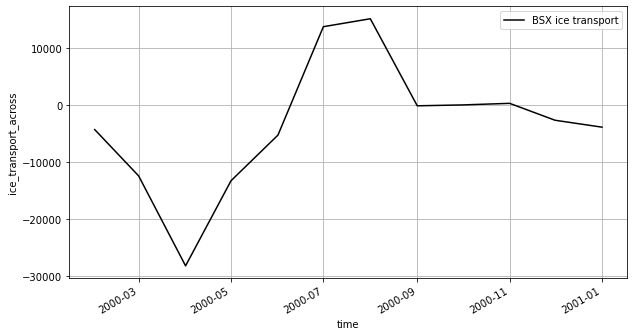

In [310]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.grid(':')
ice_transport.plot(ax=ax, color='k', label='BSX ice transport')
plt.legend()